In [1]:
import pandas as pd
import numpy as np
import re, os, ast, glob
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
from google.colab import drive
drive.mount('/content/drive')

project_root = Path("/content/drive/MyDrive/2025_Projects/MultiPEC/")

Mounted at /content/drive


In [3]:
# Original labels including A1, A2 (which were at index 31 and 32)
channels_labels = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", "T7",
    "C3", "C4", "T8", "TP9", "CP5", "CP1", "CP2", "CP6", "TP10", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2", "Iz", "AF7", "AF3", "AFz", "AF4",
    "AF8", "F5", "F1", "F2", "F6", "FT7", "FC3", "FCz", "FC4", "FT8", "C5", "C1",
    "C2", "C6", "TP7", "CP3", "CPz", "CP4", "TP8", "P5", "P1", "P2", "P6", "PO7",
    "PO3", "POz", "PO4", "PO8"
]

eeg_info = {
    "Fp1": ("Frontal pole", "attention, emotion, executive function"),
    "Fp2": ("Frontal pole", "attention, emotion, executive function"),
    "F7": ("Frontal", "language processing, auditory processing"),
    "F3": ("Frontal", "working memory, decision making"),
    "Fz": ("Frontal midline", "executive control, motor planning"),
    "F4": ("Frontal", "working memory, decision making"),
    "F8": ("Frontal", "language, auditory response"),
    "FC5": ("Fronto-central", "speech perception, auditory-motor integration"),
    "FC1": ("Fronto-central", "motor planning, decision making"),
    "FC2": ("Fronto-central", "motor planning, decision making"),
    "FC6": ("Fronto-central", "auditory-motor integration"),
    "T7": ("Temporal", "primary auditory processing"),
    "C3": ("Central", "motor cortex - movement of right side"),
    "C4": ("Central", "motor cortex - movement of left side"),
    "T8": ("Temporal", "auditory association"),
    "TP9": ("Temporal-parietal", "sound localization, multisensory integration"),
    "CP5": ("Centro-parietal", "sensorimotor integration"),
    "CP1": ("Centro-parietal", "tactile processing, spatial attention"),
    "CP2": ("Centro-parietal", "tactile processing, spatial attention"),
    "CP6": ("Centro-parietal", "sensorimotor integration"),
    "TP10": ("Temporal-parietal", "sound localization, multisensory integration"),
    "P7": ("Parietal", "visual attention, spatial processing"),
    "P3": ("Parietal", "spatial awareness, somatosensory integration"),
    "Pz": ("Parietal midline", "visuospatial attention, awareness"),
    "P4": ("Parietal", "spatial awareness, somatosensory integration"),
    "P8": ("Parietal", "visual attention, spatial processing"),
    "O1": ("Occipital", "primary visual cortex (left visual field)"),
    "Oz": ("Occipital midline", "central visual processing"),
    "O2": ("Occipital", "primary visual cortex (right visual field)"),
    "Iz": ("Occipital", "visual association area"),
    "A1": ("Reference electrode", "reference"),
    "A2": ("Reference electrode", "reference"),
    "AF7": ("Anterior frontal", "language and auditory attention"),
    "AF3": ("Anterior frontal", "emotional control, working memory"),
    "AFz": ("Anterior frontal midline", "conflict monitoring, executive control"),
    "AF4": ("Anterior frontal", "emotional control, working memory"),
    "AF8": ("Anterior frontal", "language and auditory attention"),
    "F5": ("Frontal", "motor planning, cognitive control"),
    "F1": ("Frontal", "executive function, motor planning"),
    "F2": ("Frontal", "executive function, motor planning"),
    "F6": ("Frontal", "motor planning, cognitive control"),
    "FT7": ("Fronto-temporal", "auditory processing, speech perception"),
    "FC3": ("Fronto-central", "motor preparation, sensorimotor integration"),
    "FCz": ("Fronto-central midline", "motor control, attention"),
    "FC4": ("Fronto-central", "motor preparation, sensorimotor integration"),
    "FT8": ("Fronto-temporal", "auditory processing, speech perception"),
    "C5": ("Central", "motor cortex - movement of right limbs"),
    "C1": ("Central", "motor cortex - fine motor control (right)"),
    "C2": ("Central", "motor cortex - fine motor control (left)"),
    "C6": ("Central", "motor cortex - movement of left limbs"),
    "TP7": ("Temporal-parietal", "speech and language integration"),
    "CP3": ("Centro-parietal", "sensorimotor function, spatial processing"),
    "CPz": ("Centro-parietal midline", "sensorimotor integration"),
    "CP4": ("Centro-parietal", "sensorimotor function, spatial processing"),
    "TP8": ("Temporal-parietal", "speech and language integration"),
    "P5": ("Parietal", "visual attention, object recognition"),
    "P1": ("Parietal", "visual spatial processing"),
    "P2": ("Parietal", "visual spatial processing"),
    "P6": ("Parietal", "visual attention, object recognition"),
    "PO7": ("Parieto-occipital", "high-level visual processing"),
    "PO3": ("Parieto-occipital", "visual integration, object recognition"),
    "POz": ("Parieto-occipital midline", "visual attention and processing"),
    "PO4": ("Parieto-occipital", "visual integration, object recognition"),
    "PO8": ("Parieto-occipital", "high-level visual processing")
}

function_map = {
    "visual": ["visual", "object recognition", "spatial", "association", "high-level"],
    "auditory": ["auditory", "sound"],
    "language": ["language", "speech"],
    "motor": ["motor", "movement", "fine motor"],
    "executive": ["executive", "decision", "working memory", "control", "conflict"],
    "attention": ["attention", "focus"],
    "sensorimotor": ["sensorimotor", "tactile", "somatosensory"],
    "emotion": ["emotion", "emotional"],
}

def get_original_index(modified_index):
    return modified_index + 2 if modified_index >= 31 else modified_index

def describe_eeg_channels(indices):
    results = []
    for idx in indices:
        original_idx = get_original_index(idx)
        label = channels_labels[original_idx]
        region, modality = eeg_info.get(label, ("Unknown region", "unknown"))
        results.append({
            "index": idx,
            "original_label": label,
            "brain_region": region,
            "processing_type": modality
        })
    return results

def map_processing_type(processing_str):
    processing_str = processing_str.lower()
    tags = set()
    for group, keywords in function_map.items():
        for kw in keywords:
            if kw in processing_str:
                tags.add(group)
                break
    return list(tags)

# Parse a single Excel file
def parse_subject_file(filepath):
    df = pd.read_excel(filepath)
    df['Net Nodes'] = df['Net Nodes'].apply(ast.literal_eval)
    df['Processing Tags'] = df['Processing Type'].apply(map_processing_type)
    return df

# Process all Excel files in folder
def process_all_subjects(data_folder='data'):
    files = glob.glob(f"{data_folder}/nets_*_S*_*.xlsx")
    all_networks = []

    for file in files:
        match = re.search(r'nets_(3down|23|12)_(S\d+)_(\d+)\.xlsx', file)
        if not match:
            continue

        sigma, task, subject_id = match.groups()
        subject_id = f"sub{subject_id}"
        df = parse_subject_file(file)

        # Temp dict to collect unique networks
        net_dict = {}

        for _, row in df.iterrows():
            key = (task, subject_id, row['Net Nodes'])
            if key not in net_dict:
                net_dict[key] = {
                    'task': task,
                    'subject': subject_id,
                    'net_nodes': row['Net Nodes'],
                    'pec': row['Last PEC Value'],
                    'tags': set(row['Processing Tags']),
                }
            else:
                net_dict[key]['tags'].update(row['Processing Tags'])

        # Add unique entries to the result
        for net in net_dict.values():
            net['tags'] = sorted(net['tags'])  # optional
            all_networks.append(net)

    return all_networks

# Summarize per subject and group
def summarize_group(networks, top_n=3):
    per_subject_summary = defaultdict(lambda: defaultdict(list))
    group_tag_summary = defaultdict(list)

    for net in networks:
        subj = net['subject']
        task = net['task']
        key = f"{subj}_{task}"
        per_subject_summary[key]['networks'].append(net)

    per_subject_lowpec = {}
    for key, data in per_subject_summary.items():
        top_networks = sorted(data['networks'], key=lambda x: x['pec'])[:top_n]
        tag_counter = defaultdict(int)

        for net in top_networks:
            for tag in net['tags']:
                tag_counter[tag] += 1
                group_tag_summary[tag].append(net['pec'])

        per_subject_lowpec[key] = tag_counter

    return per_subject_lowpec, group_tag_summary

Check channel (node) functions:

In [4]:
# Generate node_functions from eeg_info
node_functions = {}

for idx, label in enumerate(channels_labels):
    region, functions = eeg_info.get(label, ("Unknown", ""))
    # Split the function string into a list of stripped keywords
    function_keywords = [f.strip() for f in functions.split(",") if f.strip()]
    node_functions[idx] = function_keywords

print("Node functions:", node_functions)

Node functions: {0: ['attention', 'emotion', 'executive function'], 1: ['attention', 'emotion', 'executive function'], 2: ['language processing', 'auditory processing'], 3: ['working memory', 'decision making'], 4: ['executive control', 'motor planning'], 5: ['working memory', 'decision making'], 6: ['language', 'auditory response'], 7: ['speech perception', 'auditory-motor integration'], 8: ['motor planning', 'decision making'], 9: ['motor planning', 'decision making'], 10: ['auditory-motor integration'], 11: ['primary auditory processing'], 12: ['motor cortex - movement of right side'], 13: ['motor cortex - movement of left side'], 14: ['auditory association'], 15: ['sound localization', 'multisensory integration'], 16: ['sensorimotor integration'], 17: ['tactile processing', 'spatial attention'], 18: ['tactile processing', 'spatial attention'], 19: ['sensorimotor integration'], 20: ['sound localization', 'multisensory integration'], 21: ['visual attention', 'spatial processing'], 22

In [5]:
function_weights = {
    # General / always-on
    'attention': 1,
    'executive function': 2,
    'working memory': 3,
    'emotional control': 4,
    'spatial awareness': 5,
    'sensorimotor integration': 6,
    'visual attention': 7,
    'visual processing': 8,

    # Visual task-specific
    'primary visual cortex (left visual field)': 9,
    'primary visual cortex (right visual field)': 10,
    'visual spatial processing': 11,
    'high-level visual processing': 12,
    'object recognition': 13,
    'visual integration': 14,

    # Audio task-specific
    'auditory-motor integration': 15,
    'primary auditory processing': 16,
    'speech perception': 17,
    'speech and language integration': 18,
    'language': 19,
    'language processing': 20,
    'sound localization': 21,
    'auditory association': 22,
    'auditory processing': 23,

    # Other
    'motor planning': 24,
    'motor cortex - movement of left limbs': 25,
    'motor cortex - movement of right limbs': 26,
    'spatial processing': 27,
    'conflict monitoring': 28,
    'decision making': 29,
    'emotional regulation': 30,
    'tactile processing': 31,
}

In [6]:
def generate_function_map(eeg_info, function_weights):
    function_map = defaultdict(list)
    for ch, (_, functions_str) in eeg_info.items():
        for function in function_weights:
            # Match by substring (case-insensitive)
            if function.lower() in functions_str.lower():
                function_map[function].append(ch)
    return dict(function_map)

FUNCTION_MAP = generate_function_map(eeg_info, function_weights)
print(FUNCTION_MAP)

{'attention': ['Fp1', 'Fp2', 'CP1', 'CP2', 'P7', 'Pz', 'P8', 'AF7', 'AF8', 'FCz', 'P5', 'P6', 'POz'], 'executive function': ['Fp1', 'Fp2', 'F1', 'F2'], 'language': ['F7', 'F8', 'AF7', 'AF8', 'TP7', 'TP8'], 'language processing': ['F7'], 'auditory processing': ['F7', 'T7', 'FT7', 'FT8'], 'working memory': ['F3', 'F4', 'AF3', 'AF4'], 'decision making': ['F3', 'F4', 'FC1', 'FC2'], 'motor planning': ['Fz', 'FC1', 'FC2', 'F5', 'F1', 'F2', 'F6'], 'auditory-motor integration': ['FC5', 'FC6'], 'speech perception': ['FC5', 'FT7', 'FT8'], 'primary auditory processing': ['T7'], 'auditory association': ['T8'], 'sound localization': ['TP9', 'TP10'], 'sensorimotor integration': ['CP5', 'CP6', 'FC3', 'FC4', 'CPz'], 'tactile processing': ['CP1', 'CP2'], 'visual attention': ['P7', 'P8', 'P5', 'P6', 'POz'], 'spatial processing': ['P7', 'P8', 'CP3', 'CP4', 'P1', 'P2'], 'spatial awareness': ['P3', 'P4'], 'primary visual cortex (left visual field)': ['O1'], 'visual processing': ['Oz', 'PO7', 'PO8'], 'prima

Define path to the network files.

In [7]:
output_folder = project_root/"nets"
figures_folder = project_root

all_networks = process_all_subjects(data_folder=output_folder)
print(f"Found {len(all_networks)} total networks across all files.")



Found 4863 total networks across all files.


In [8]:

from collections import Counter

# Convert the list of dicts into a DataFrame
df_nets = pd.DataFrame(all_networks)

# Count number of networks per class (task S1–S7)
task_distribution = df_nets['task'].value_counts().sort_index()

# Print or visualize
print("Number of networks per task:")
print(task_distribution)


Number of networks per task:
task
S1    580
S2    565
S3    938
S4    628
S5    872
S6    704
S7    576
Name: count, dtype: int64


Summarize the networks per task (per subject summary, and then group summary).

In [9]:
def load_subject(id=1, data_folder=output_folder):
    """
    Load all networks for a single subject, ensuring data exists for all tasks S1–S7.

    Parameters:
    - id (int): Subject ID to load.
    - data_folder (str): Path to folder containing the .xlsx network files.

    Returns:
    - all_networks (list of dicts): Each dict has keys: subject, task, net_nodes, pec, tags.

    Raises:
    - ValueError if any of the tasks (S1–S7) are missing.
    """
    expected_tasks = {f"S{i}" for i in range(1, 7)}
    all_networks = []
    found_tasks = set()

    pattern = re.compile(r'nets_(3down|23|12)_(S\d+)_(\d+)\.xlsx$')
    files = glob.glob(os.path.join(data_folder, f"nets_*_S*_{id}.xlsx"))

    for file in files:
        match = pattern.search(file)
        if not match:
            continue

        sigma, task, subject_id = match.groups()
        found_tasks.add(task)

        subject_id = f"subj{subject_id}"
        df = parse_subject_file(file)

        # Temp dict to collect unique networks
        net_dict = {}

        for _, row in df.iterrows():
            key = (task, subject_id, row['Net Nodes'])
            if key not in net_dict:
                net_dict[key] = {
                    'task': task,
                    'subject': subject_id,
                    'net_nodes': row['Net Nodes'],
                    'pec': row['Last PEC Value'],
                    'tags': set(row['Processing Tags']),
                }
            else:
                net_dict[key]['tags'].update(row['Processing Tags'])

        # Add unique entries to the result
        for net in net_dict.values():
            net['tags'] = sorted(net['tags'])  # optional
            all_networks.append(net)

    # Check if all required tasks are present
    missing_tasks = expected_tasks - found_tasks
    if missing_tasks:
        raise ValueError(f"Subject {id} is missing data for task(s): {', '.join(sorted(missing_tasks))}")

    return all_networks



In [10]:
import matplotlib.patches as patches

def plot_function_heatmap(df, plot_title="Function Contributions Across Networks", results_path=Path("classification_clustering_reports")):
    subject = df.index[0].split('_')[0]
    results_path.mkdir(exist_ok=True)

    # Transpose for heatmap
    data = df.T

    # Remove functions (rows) with all zeros
    data = data.loc[~(data == 0).all(axis=1)]

    # Sort functions by predefined order
    ordered_functions = [f for f in function_weights if f in data.index]
    data_plot = data.loc[ordered_functions]

    # Create heatmap figure
    fig, ax = plt.subplots(figsize=(min(0.1 * len(data_plot.columns), 20), 12))
    sns.heatmap(data_plot, cmap="mako", cbar_kws={'label': 'PEC-weighted score'}, ax=ax)

    # Parse task labels (e.g., "S1", "S2")
    task_labels = [idx.split('_')[1] for idx in df.index]; print(task_labels)

    # Track start and end positions for each task
    task_positions = {}
    for i, task in enumerate(task_labels):
        if task not in task_positions:
            task_positions[task] = [i, i]
        else:
            task_positions[task][1] = i

    # Clear default xticks
    ax.set_xticks([])

    # Draw group labels under x-axis
    for task, (start, end) in task_positions.items():
        center = (start + end) / 2
        ax.text(center + 0.5, len(data_plot.index) + 0.5, task,
                ha='center', va='top', fontsize=14, rotation=0)

        # Optional: Draw vertical line to separate task blocks
        ax.add_patch(patches.Rectangle((start, 0), end - start + 1, len(data_plot.index),
                                       linewidth=0.5, edgecolor='white', facecolor='none'))

    # Set labels
    ax.set_xlabel("")
    ax.set_ylabel("Cognitive Functions", labelpad=15)
    ax.set_title(plot_title, pad=25)

    # Save and show
    plt.tight_layout()
    plt.savefig(results_path / f"{subject}_vectors.pdf", bbox_inches='tight')
    plt.show()

def generate_function_vectors(networks, node_functions, function_weights, plot_type='heatmap'):
    # Get all cognitive functions mapped by the 64-channel EEG
    all_functions = sorted({func for funcs in node_functions.values() for func in funcs})

    # Normalize PECs across all networks
    all_pecs = [net['pec'] for net in networks]
    max_pec = max(all_pecs)
    min_pec = min(all_pecs)

    def normalize_pec(pec):
        return 1 - (pec - min_pec) / (max_pec - min_pec + 1e-6)

    data = []
    ids = []

    for net in networks:
        weighted_vector = defaultdict(float)
        pec_weight = normalize_pec(net['pec'])

        for node in net['net_nodes']:
            funcs = node_functions.get(node, [])
            for f in funcs:
                base_weight = function_weights.get(f, 0.0)
                weighted_vector[f] += pec_weight * base_weight

        vec = [weighted_vector.get(f, 0.0) for f in all_functions]
        data.append(vec)
        ids.append(f"{net['subject']}_{net['task']}")

    df = pd.DataFrame(data, columns=all_functions, index=ids)

    if plot_type == 'bar':
        avg_weights = df.mean().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=avg_weights.values, y=avg_weights.index, palette="viridis")
        plt.title("Average PEC-weighted Function Contributions")
        plt.xlabel("Weighted Importance")
        plt.tight_layout()
        plt.show()

    elif plot_type == 'heatmap':
        # Sort columns (functions) by mean importance (descending)
        sorted_columns = df.mean(axis=0).sort_values(ascending=False).index.tolist()

        # Sort rows (network IDs) by subject and task
        sorted_index = sorted(df.index, key=lambda x: (x.split('_')[1], x.split('_')[0]))

        # Apply the sorting to the dataframe
        df_sorted = df.loc[sorted_index, sorted_columns]

        plot_function_heatmap(df_sorted)

    return df


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, accuracy_score,
    precision_score, recall_score, roc_auc_score, average_precision_score,
    ConfusionMatrixDisplay, silhouette_score, adjusted_rand_score,
    normalized_mutual_info_score
)

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', context='talk')

def preprocess_data(X, y_raw):
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    y_classes = le.classes_
    class_counts = pd.Series(y_raw).value_counts()
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled, y, y_classes, class_counts

def evaluate_classifier(X, y, class_names, n_splits=5, plot=False):
    from sklearn.exceptions import NotFittedError

    # Count class frequencies
    class_counts = pd.Series(y).value_counts()
    valid_classes = class_counts[class_counts >= n_splits].index.tolist()

    if len(valid_classes) < 2:
        raise ValueError("Not enough valid classes for classification after filtering.")

    # Filter and relabel
    valid_mask = np.isin(y, valid_classes)
    X = X[valid_mask]
    y = y[valid_mask]
    label_map = {old: new for new, old in enumerate(sorted(valid_classes))}
    y = np.array([label_map[yi] for yi in y])
    class_names = [class_names[i] for i in sorted(valid_classes)]

    print(f"Including classes: {class_names}")

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

    all_y_true, all_y_pred, all_y_proba = [], [], []
    cm_total = np.zeros((len(class_names), len(class_names)))
    all_coefs = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf.fit(X_train, y_train)

        # Collect feature importances
        try:
            coefs = clf.coef_
            all_coefs.append(coefs)
        except NotFittedError:
            print("Model not fitted, skipping coefficients.")

        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_proba.extend(y_proba)
        cm_total += confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))

    all_y_true = np.array(all_y_true)
    all_y_pred = np.array(all_y_pred)
    all_y_proba = np.array(all_y_proba)

    # Metrics
    report = classification_report(all_y_true, all_y_pred, target_names=class_names, output_dict=True)
    f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    acc = accuracy_score(all_y_true, all_y_pred)
    precision = precision_score(all_y_true, all_y_pred, average='weighted')
    recall = recall_score(all_y_true, all_y_pred, average='weighted')
    roc_auc = roc_auc_score(
        label_binarize(all_y_true, classes=np.arange(len(class_names))),
        all_y_proba,
        average='macro',
        multi_class='ovr'
    )

    metrics_df = pd.DataFrame(report).transpose()
    metrics_df['support'] = metrics_df['support'].astype(int)

    # Average feature importances
    if len(all_coefs) > 0:
        all_coefs = np.array(all_coefs)  # shape: (n_folds, n_classes, n_features)
        if all_coefs.ndim == 3:
            avg_importance = np.mean(np.abs(all_coefs), axis=(0, 1))  # mean over folds and classes
        else:
            avg_importance = np.mean(np.abs(all_coefs), axis=0)
    else:
        avg_importance = np.zeros(X.shape[1])
        print("Warning: No coefficients collected.")

    # Plot confusion matrix if needed
    if plot:
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm_total, annot=True, fmt='.0f',
                    xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{subject_id}_confusion_matrix.pdf"), bbox_inches='tight')
        plt.show()

    return metrics_df, cm_total, f1, acc, precision, recall, roc_auc, class_names, avg_importance


In [17]:
output_dir = Path("classification_clustering_reports")
output_dir.mkdir(exist_ok=True)
results_path = "classification_clustering_reports"  # adjust as needed

feature_importances = []

for subject_id in range(1,25):
    print(f"\nProcessing Subject {subject_id}")
    try:
        # Load subject data
        subject_data = load_subject(id=subject_id)
        df_vectors = generate_function_vectors(subject_data, node_functions, function_weights, plot_type=None)
        # Preprocess
        X = df_vectors.values
        y_raw = [idx.split('_')[1] for idx in df_vectors.index]
        X_scaled, y, y_classes, class_counts = preprocess_data(X, y_raw)

        if len(np.unique(y)) < 2:
            print(f"Subject {subject_id}: Less than 2 classes present. Skipping.")
            continue
        # Classify
        metrics_df, cm_total, f1, acc, prec, rec, auc, class_names, importances = evaluate_classifier(X_scaled, y, y_classes, plot=False)

        feature_importances.append(importances)

        metrics_df.to_csv(output_dir / f"subject_{subject_id}_classification_metrics.csv")
        pd.DataFrame(cm_total, index=class_names, columns=class_names).to_csv(
            output_dir / f"subject_{subject_id}_confusion_matrix.csv"
        )

    except Exception as e:
        print(f"Subject {subject_id} failed: {e}")
        continue



Processing Subject 1
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 2
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 3
Including classes: [np.str_('S3'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 4
Subject 4 failed: Not enough valid classes for classification after filtering.

Processing Subject 5
Including classes: [np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 6
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 7
Including classes: [np.str_('S3'), np.str_('S5'), np.str_('S6'), np.str_('S7')]

Processing Subject 8
Including classes: [np.str_('S1'), np.str_('S2'), np.str_('S3'), np.str_('S4'), np.str_('S5'), np.st

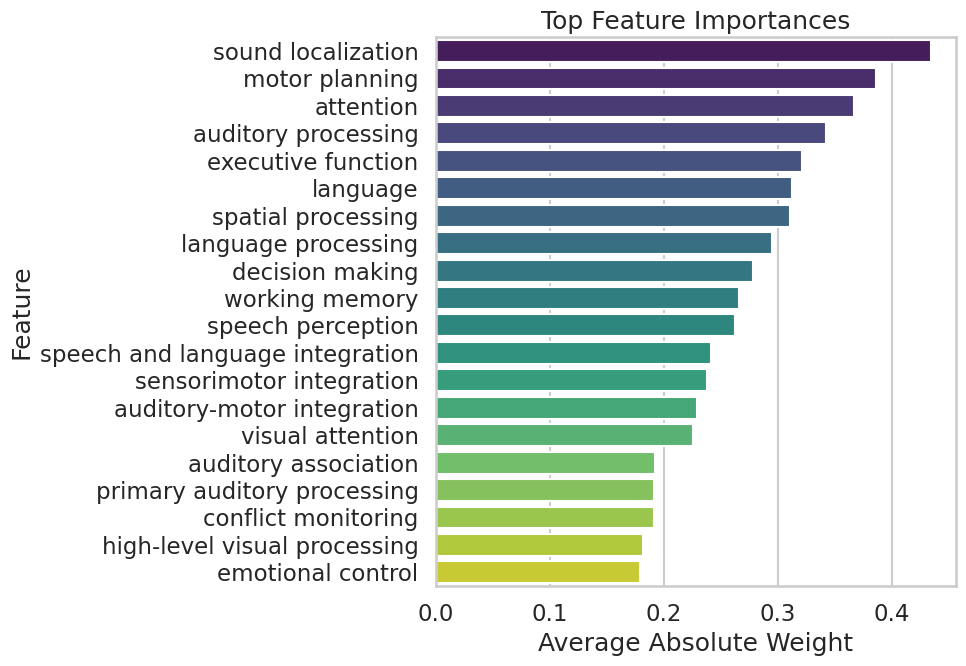

In [26]:
def plot_top_features(avg_importance, feature_names=None, top_n=20, title="Top Feature Importances", save_path=None):
    """
    Plot the top N most important features from averaged SVM coefficients.

    Parameters:
    - avg_importance (array-like): Importance values (e.g., mean of abs(coef_)).
    - feature_names (list or None): List of actual feature labels. If None, uses F0, F1, ...
    - top_n (int): Number of top features to show.
    - title (str): Plot title.
    - save_path (str or None): If provided, saves the figure to this path.
    """
    # Default to generic feature labels if not provided
    if feature_names is None:
        feature_names = [f"F{i}" for i in range(len(avg_importance))]

    if len(feature_names) != len(avg_importance):
        raise ValueError("Length of feature_names must match length of avg_importance.")

    # Create a DataFrame for easier sorting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': avg_importance
    })

    # Select top N features by importance
    top_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(10, 7))
    sns.barplot(data=top_df, x='Importance', y='Feature', palette='viridis')
    plt.title(title)
    plt.xlabel('Average Absolute Weight')
    plt.ylabel('Feature')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


feature_labels = df_vectors.columns.tolist()

mean_importance = np.mean(feature_importances, axis=0)
plot_top_features(mean_importance, feature_names=feature_labels, top_n=20, save_path=os.path.join(output_dir, "feature_importances.pdf"))


precision normality p-values per class: [('S1', np.float64(0.4340822910296805)), ('S2', np.float64(0.3478090592312532)), ('S3', np.float64(0.3783286770677496)), ('S4', np.float64(0.9916931129501837)), ('S5', np.float64(0.6765582401069161)), ('S6', np.float64(0.13304173957284743)), ('S7', np.float64(0.2808315613437462))]
Levene test p-value: 0.9004
precision: Using ANOVA + Tukey
ANOVA p-value: 0.2999

recall normality p-values per class: [('S1', np.float64(0.3810547115445746)), ('S2', np.float64(0.11061466323193397)), ('S3', np.float64(0.8402230846752239)), ('S4', np.float64(0.7785453761735031)), ('S5', np.float64(0.10661083031538976)), ('S6', np.float64(0.47004275288702635)), ('S7', np.float64(0.19895435273409717))]
Levene test p-value: 0.4239
recall: Using ANOVA + Tukey
ANOVA p-value: 0.0215

f1-score normality p-values per class: [('S1', np.float64(0.5100145732585397)), ('S2', np.float64(0.591300305722757)), ('S3', np.float64(0.8579515708828321)), ('S4', np.float64(0.973414368473799

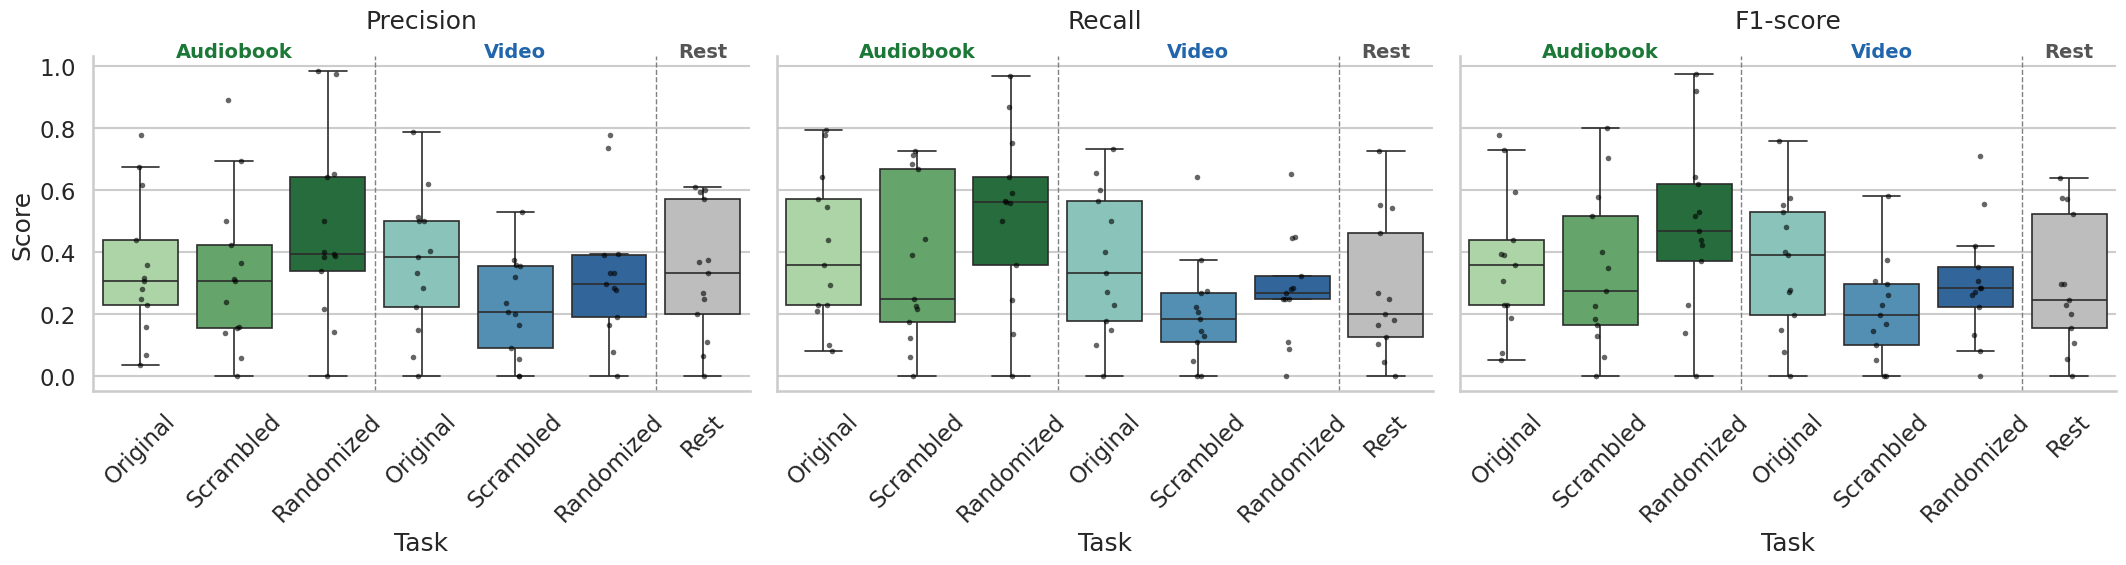

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, f_oneway, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Paths and settings
results_path = "classification_clustering_reports/"
metrics_files = sorted(glob.glob(os.path.join(results_path, "subject_*_metrics.csv")))
ordered_classes = [f'S{i}' for i in range(1, 8)]
task_labels = {
    'S1': 'Original',
    'S2': 'Scrambled',
    'S3': 'Randomized',
    'S4': 'Original',
    'S5': 'Scrambled',
    'S6': 'Randomized',
    'S7': 'Rest'
}
custom_palette = {
    'S1': '#a6dba0',
    'S2': '#5aae61',
    'S3': '#1b7837',
    'S4': '#80cdc1',
    'S5': '#4393c3',
    'S6': '#2166ac',
    'S7': '#bdbdbd'
}

# Load and filter data: only keep files with all classes S1-S7
all_metrics = []
for m_file in metrics_files:
    df = pd.read_csv(m_file, index_col=0)
    df = df.loc[~df.index.str.contains('avg|accuracy', case=False)]
    present_classes = set(df.index.tolist())
    if all(cls in present_classes for cls in ordered_classes):
        all_metrics.append(df)

# Combine and reshape data
df_all_metrics = pd.concat(all_metrics)
df_melted = df_all_metrics.reset_index().melt(
    id_vars='index',
    value_vars=['precision', 'recall', 'f1-score'],
    var_name='Metric',
    value_name='Score'
)
df_melted.rename(columns={'index': 'Class'}, inplace=True)
df_melted['Task'] = df_melted['Class'].map(task_labels)
df_melted['Color'] = df_melted['Class'].map(custom_palette)

# Plot setup
sns.set(style='whitegrid', context='talk')
g = sns.catplot(
    data=df_melted, kind='box',
    x='Class', y='Score', col='Metric',
    col_order=['precision', 'recall', 'f1-score'],
    order=ordered_classes,
    sharey=True, sharex=True,
    height=6, aspect=1.2,
    palette=custom_palette,
    linewidth=1.2,
    dodge=False,
    showfliers=False
)

# Add jittered points, vertical lines, group titles, and labels
for ax, metric in zip(g.axes[0], ['precision', 'recall', 'f1-score']):
    subset = df_melted[df_melted['Metric'] == metric]

    sns.stripplot(
        data=subset, x='Class', y='Score', order=ordered_classes,
        color='black', size=4, jitter=True, alpha=0.6, ax=ax
    )

    # Vertical group divider lines
    ax.axvline(x=2.5, color='gray', linestyle='--', linewidth=1)
    ax.axvline(x=5.5, color='gray', linestyle='--', linewidth=1)

    # Group titles
    ax.text(1, 1.03, 'Audiobook', ha='center', fontsize=14, color='#1b7837', weight='bold')
    ax.text(4, 1.03, 'Video', ha='center', fontsize=14, color='#2166ac', weight='bold')
    ax.text(6, 1.03, 'Rest', ha='center', fontsize=14, color='#555555', weight='bold')

    ax.set_title(f'{metric.capitalize()}', pad=20)
    ax.set_xlabel('Task')
    ax.set_ylabel('Score')
    ax.set_xticklabels([task_labels[c] for c in ordered_classes], rotation=45)

# Function to convert p-values to stars
def pval_to_stars(p):
    if p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return ''

# Statistical testing & annotation
for ax, metric in zip(g.axes[0], ['precision', 'recall', 'f1-score']):
    subset = df_melted[df_melted['Metric'] == metric]
    groups = [subset[subset['Class'] == cls]['Score'].values for cls in ordered_classes]

    # Check normality per group (Shapiro-Wilk)
    normality_pvals = [shapiro(g)[1] if len(g) >= 3 else 1 for g in groups]
    # Check homogeneity of variances (Levene)
    lev_stat, lev_p = levene(*groups)

    print(f"\n{metric} normality p-values per class:", list(zip(ordered_classes, normality_pvals)))
    print(f"Levene test p-value: {lev_p:.4f}")

    if all(p > 0.05 for p in normality_pvals) and lev_p > 0.05:
        print(f"{metric}: Using ANOVA + Tukey")
        anova_stat, anova_p = f_oneway(*groups)
        print(f"ANOVA p-value: {anova_p:.4f}")
        sig_pairs = []
        if anova_p <= 0.05:
            tukey = pairwise_tukeyhsd(endog=subset['Score'], groups=subset['Class'], alpha=0.05)
            for res in tukey.summary()[1:]:
                g1 = str(res[0]).strip()
                g2 = str(res[1]).strip()
                p_adj = float(str(res[4]).strip())
                reject = str(res[5]).strip() == 'True'
                if reject:
                    i = ordered_classes.index(g1)
                    j = ordered_classes.index(g2)
                    sig_pairs.append((i, j, p_adj))

    else:
        print(f"{metric}: Using Mann-Whitney U tests")
        sig_pairs = []
        for i in range(len(ordered_classes)):
            for j in range(i + 1, len(ordered_classes)):
                c1, c2 = ordered_classes[i], ordered_classes[j]
                group1 = subset[subset['Class'] == c1]['Score'].values
                group2 = subset[subset['Class'] == c2]['Score'].values
                stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
                if p < 0.05:
                    sig_pairs.append((i, j, p))

    # Annotate significant pairs on plot
    y_max = subset['Score'].max()
    h = 0.04  # height of bar
    text_offset = 0.01
    for i, j, p in sig_pairs:
        y = y_max + h * (j - i) + text_offset
        ax.plot([i, i, j, j], [y, y + h, y + h, y], c='k', lw=1.2)
        ax.text((i + j) / 2, y + h, pval_to_stars(p), ha='center', va='bottom', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(results_path, "per_class_boxplots_annotated.pdf"), bbox_inches='tight')
plt.show()


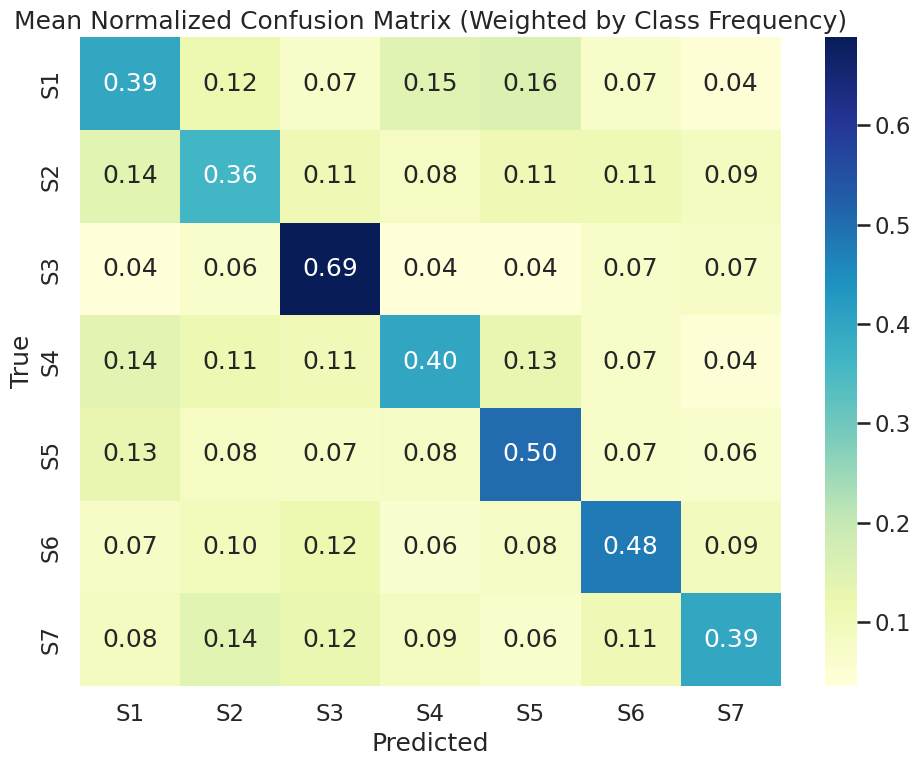


Top 10 Most Confused Class Pairs Across Subjects:

S1  S5    0.156306
    S4    0.147425
S2  S1    0.142086
S7  S2    0.140351
S4  S1    0.139573
    S5    0.128079
S5  S1    0.127635
S7  S3    0.122807
S6  S3    0.118156
S1  S2    0.117229
dtype: float64

Top 10 Most Confused Class Pairs Across Subjects:

S1  S5    0.156306
    S4    0.147425
S2  S1    0.142086
S7  S2    0.140351
S4  S1    0.139573
    S5    0.128079
S5  S1    0.127635
S7  S3    0.122807
S6  S3    0.118156
S1  S2    0.117229
dtype: float64


In [ ]:
import matplotlib.patches as mpatches

# Set paths
results_path = "classification_clustering_reports/"
metrics_files = sorted(glob.glob(os.path.join(results_path, "subject_*_metrics.csv")))
conf_matrix_files = sorted(glob.glob(os.path.join(results_path, "subject_*_confusion_matrix.csv")))

all_metrics = []
all_conf_matrices = []
class_names = None

# Load data
for m_file, c_file in zip(metrics_files, conf_matrix_files):
    df_metrics = pd.read_csv(m_file, index_col=0)
    df_metrics = df_metrics.loc[~df_metrics.index.str.contains('avg|accuracy', case=False)]
    all_metrics.append(df_metrics)

    if class_names is None:
        class_names = df_metrics.index.tolist()

    cm = pd.read_csv(c_file, index_col=0).values
    all_conf_matrices.append(cm)

# Determine full class list
all_classes = sorted(set(cls for df in all_metrics for cls in df.index))
n_classes = len(all_classes)
class_to_index = {cls: i for i, cls in enumerate(all_classes)}

# Initialize accumulators
weighted_sum_conf_matrix = np.zeros((n_classes, n_classes))
row_weights = np.zeros((n_classes,))  # total samples per true class across all matrices

# Process each subject's confusion matrix
for df_metrics, cm_raw in zip(all_metrics, all_conf_matrices):
    included_classes = df_metrics.index.tolist()
    included_indices = [class_to_index[c] for c in included_classes]

    cm_raw = cm_raw.astype(float)

    # Compute row-wise sample counts (sum over rows)
    row_sums = cm_raw.sum(axis=1)
    row_sums[row_sums == 0] = 1  # avoid division by zero

    # Row-normalize the matrix
    cm_normalized = cm_raw / row_sums[:, np.newaxis]

    # Update the full matrix with weights
    for i, row_cls_idx in enumerate(included_indices):
        n_samples = cm_raw[i].sum()
        if n_samples == 0:
            continue
        for j, col_cls_idx in enumerate(included_indices):
            weighted_sum_conf_matrix[row_cls_idx, col_cls_idx] += cm_normalized[i, j] * n_samples
        row_weights[row_cls_idx] += n_samples

# Final mean normalized confusion matrix
mean_conf_matrix = np.divide(
    weighted_sum_conf_matrix,
    row_weights[:, np.newaxis],
    out=np.zeros_like(weighted_sum_conf_matrix),
    where=row_weights[:, np.newaxis] > 0
)

# Save and plot the result
agg_cm_df = pd.DataFrame(mean_conf_matrix, index=all_classes, columns=all_classes)
agg_cm_df.to_csv(os.path.join(results_path, "aggregated_mean_normalized_confusion_matrix_weighted.csv"))

plt.figure(figsize=(10, 8))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".2f", xticklabels=all_classes, yticklabels=all_classes, cmap="YlGnBu")
plt.title("Mean Normalized Confusion Matrix (Weighted by Class Frequency)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(results_path, "mean_normalized_confusion_matrix_weighted.pdf"), bbox_inches='tight')
plt.show()

# Show most confused class pairs (off-diagonal only)
conf_df = pd.DataFrame(mean_conf_matrix, index=all_classes, columns=all_classes)
np.fill_diagonal(conf_df.values, 0)

most_confused = conf_df.stack().sort_values(ascending=False)
top_confusions = most_confused.head(10)

print("\nTop 10 Most Confused Class Pairs Across Subjects:\n")
print(top_confusions)

top_confusions.to_csv(os.path.join(results_path, "most_confused_class_pairs.csv"))

# Show most confused class pairs (off-diagonal only)
conf_df = pd.DataFrame(mean_conf_matrix, index=all_classes, columns=all_classes)
np.fill_diagonal(conf_df.values, 0)

most_confused = conf_df.stack().sort_values(ascending=False)
top_confusions = most_confused.head(10)

print("\nTop 10 Most Confused Class Pairs Across Subjects:\n")
print(top_confusions)

top_confusions.to_csv(os.path.join(results_path, "most_confused_class_pairs.csv"))

In [ ]:
print(task_distribution)

In [ ]:
from itertools import combinations

# EEG channel names by index
eeg_channel_names = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", "T7",
    "C3", "C4", "T8", "TP9", "CP5", "CP1", "CP2", "CP6", "TP10", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2", "Iz", "A1", "A2", "AF7", "AF3", "AFz", "AF4",
    "AF8", "F5", "F1", "F2", "F6", "FT7", "FC3", "FCz", "FC4", "FT8", "C5", "C1",
    "C2", "C6", "TP7", "CP3", "CPz", "CP4", "TP8", "P5", "P1", "P2", "P6", "PO7",
    "PO3", "POz", "PO4", "PO8"
]

def parse_networks(network_data):
    true_labels = []
    pec_values = []
    list_of_graphs = []

    for entry in network_data:
        task = entry['task']
        pec = entry['pec']
        net_nodes = entry['net_nodes']
        if task != "S7":
          # Generate all pairwise edges (unordered)
          edges = list(combinations(net_nodes, 2))

          # Create node label dict (node index -> label string)
          node_labels = {node: eeg_channel_names[node] for node in net_nodes}

          graph = {
              'edges': edges,
              'node_labels': node_labels
          }

          true_labels.append(task)
          pec_values.append(pec)
          list_of_graphs.append(graph)

    return true_labels, pec_values, list_of_graphs


In [ ]:
subject_data = load_subject(id=1)

# network_data = best_nets_entry
network_data = subject_data
# network_data = all_networks

true_labels, pec_values, list_of_graphs = parse_networks(network_data)

Silhouette score with KMeans: 0.44587814142542953
Silhouette score with Agglomerative: 0.556285703085286
Silhouette score with Spectral: 0.2405643911913652
Adjusted Rand Index (ARI) per Clustering Algorithm:
KMeans         : 0.806
Agglomerative  : 0.606
Spectral       : 0.159


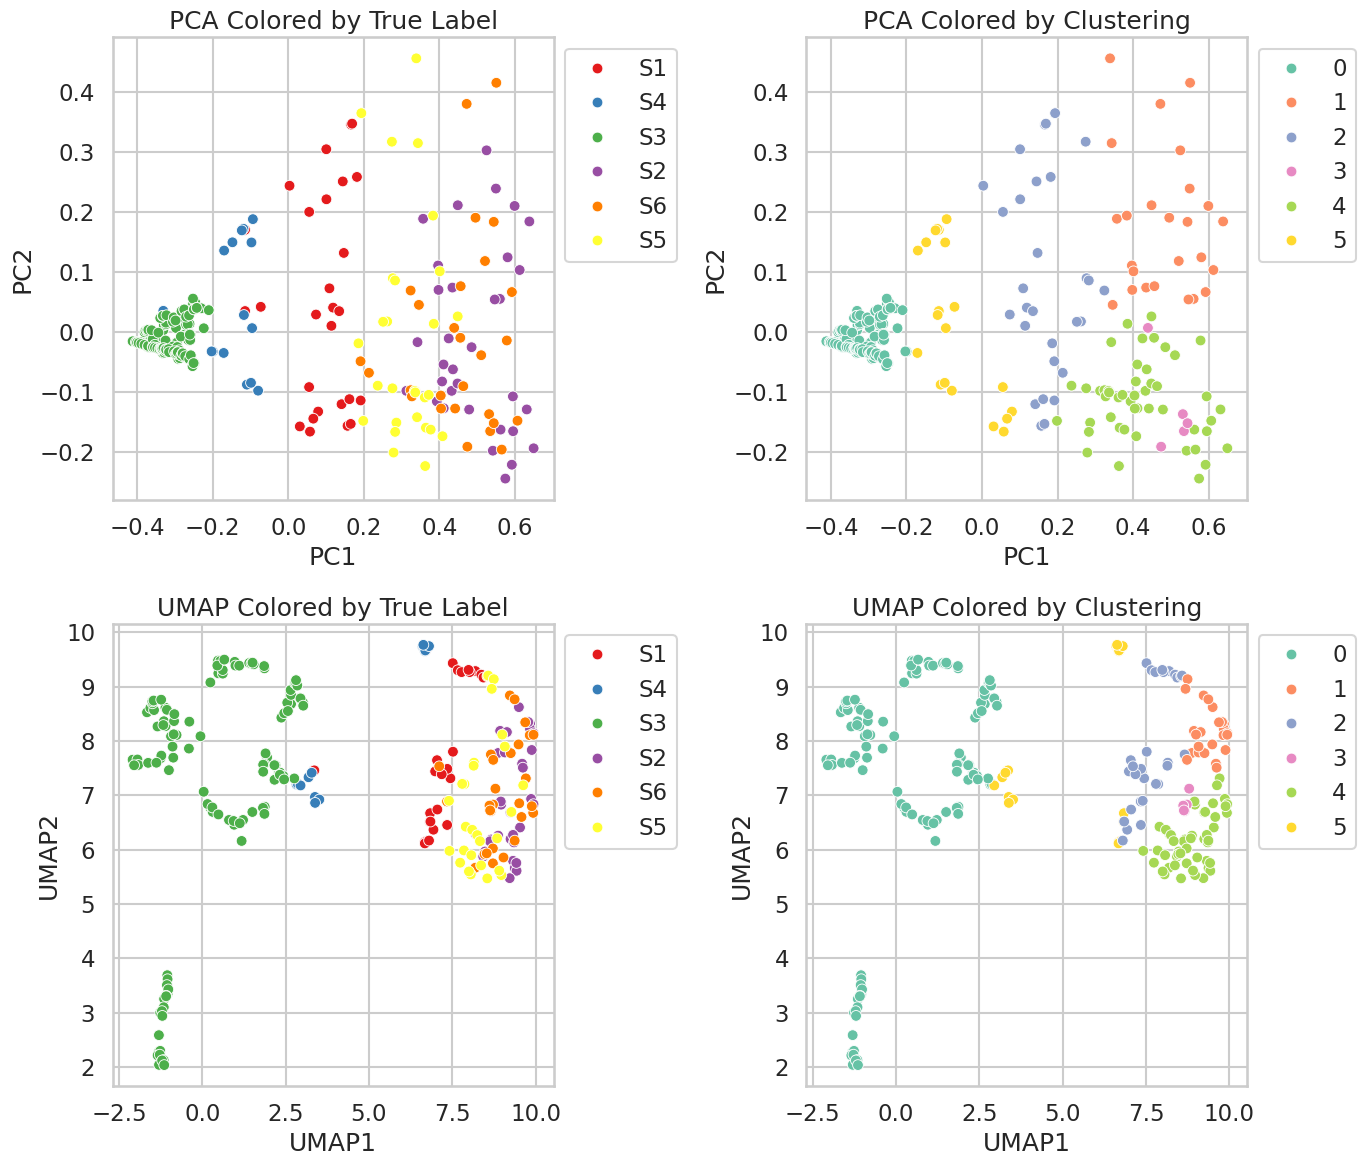

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import umap
from sklearn.metrics import silhouette_score

FUNCTION_MAP = {
    'Visual Processing': [
        "O1", "O2", "Oz", "PO3", "PO4", "POz", "PO7", "PO8"
    ],
    'Auditory Processing': [
        "T7", "T8", "TP7", "TP8", "FT7", "FT8", "TP9", "TP10"
    ],
    'Language Processing': [
        "F7", "FC5", "FC3", "F3", "T7", "TP7", "CP5"
    ],
    'Motor Control': [
        "C3", "C4", "Cz", "CP3", "CP4", "CPz"
    ],
    'Executive Function / Attention': [
        "Fp1", "Fp2", "AF3", "AF4", "Fz", "F1", "F2", "F3", "F4", "F5"
    ],
    'Somatosensory Processing': [
        "CP1", "CP2", "CP3", "CP4", "P1", "P2", "P3", "P4"
    ],
    'Memory / Default Mode Network': [
        "Pz", "POz", "Oz", "Cz", "Fz"
    ],
    'Emotion / Limbic': [
        "Fp1", "Fp2", "AF7", "AF8"
    ]
}

# Improved feature extractor with normalized counts
def func_normalized_counts(graph):
    labels = graph['node_labels'].values()
    counts = {f: 0 for f in FUNCTION_MAP}
    for ch in labels:
        for f, ch_list in FUNCTION_MAP.items():
            if ch in ch_list:
                counts[f] += 1
    total_nodes = len(labels)
    if total_nodes > 0:
        norm_counts = [counts[f]/total_nodes for f in FUNCTION_MAP]
    else:
        norm_counts = [0]*len(FUNCTION_MAP)
    return norm_counts

# Extract normalized functional features for all graphs
X_func = np.array([func_normalized_counts(g) for g in list_of_graphs])

# Scale PEC values
pec_scaled = MinMaxScaler().fit_transform(np.array(pec_values).reshape(-1, 1))

# Interaction features: PEC * normalized functional counts (excluding node count)
interaction = pec_scaled * X_func

# Combine: normalized function features + node count + PEC + interactions
X = np.hstack([pec_scaled, interaction])

# Clustering algorithms to run
clustering_algos = {
    "KMeans": KMeans(n_clusters=6, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=6, linkage="average"),
    "Spectral": SpectralClustering(n_clusters=6, affinity='nearest_neighbors', n_neighbors=5, assign_labels='kmeans', random_state=42),
}

ari_scores = {}
cluster_preds = {}

for name, algo in clustering_algos.items():
    preds = algo.fit_predict(X)
    ari = adjusted_rand_score(true_labels, preds)
    ari_scores[name] = ari
    cluster_preds[name] = preds
    print(f"Silhouette score with {name}:", silhouette_score(X, preds))

print("Adjusted Rand Index (ARI) per Clustering Algorithm:")
for name, score in ari_scores.items():
    print(f"{name:<15}: {score:.3f}")

# Dimensionality reduction for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Prepare DataFrame for plotting
df = pd.DataFrame({
    "PC1": X_pca[:,0],
    "PC2": X_pca[:,1],
    "UMAP1": X_umap[:,0],
    "UMAP2": X_umap[:,1],
    "TrueLabel": [str(t) for t in true_labels],
    "KMeans": cluster_preds["KMeans"],
    "Agglomerative": cluster_preds["Agglomerative"],
    "Spectral": cluster_preds["Spectral"],
})

# Plot PCA colored by true label and clusters
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="TrueLabel", palette="Set1", s=60)
plt.title("PCA Colored by True Label")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x="PC1", y="PC2", hue="KMeans", palette="Set2", s=60)
plt.title("PCA Colored by Clustering")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

# Plot UMAP colored by true label and clusters
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="TrueLabel", palette="Set1", s=60)
plt.title("UMAP Colored by True Label")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="KMeans", palette="Set2", s=60)
plt.title("UMAP Colored by Clustering")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


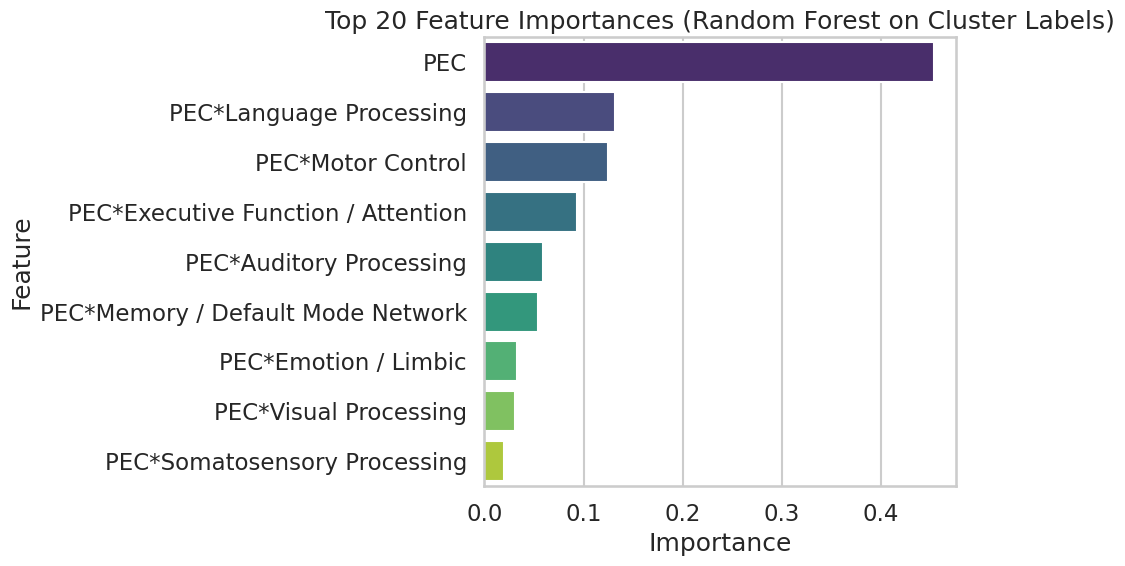

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Use cluster labels from Agglomerative clustering as pseudo-labels
y_clusters = cluster_preds["Agglomerative"]

# Use original high-dimensional features (not PCA/UMAP) for feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y_clusters)

# Get feature importances
importances = rf.feature_importances_

# --- Labeling features ---
# Functional features (normalized node counts)
func_feats = list(FUNCTION_MAP.keys())

# PEC and interactions
pec_feats = ["PEC"]
interaction_feats = [f"PEC*{f}" for f in func_feats]

# Final feature order (as used in X: PEC + interactions)
feature_names = pec_feats + interaction_feats

# Sanity check
assert len(feature_names) == X.shape[1], "Feature name count doesn't match input shape."

# Create DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 Feature Importances (Random Forest on Cluster Labels)")
plt.tight_layout()
plt.show()


In [ ]:
import shutil

# Create a folder in your Google Drive to hold the results
target_path = "/content/drive/MyDrive/2025_Projects/MultiPEC/classification_reports"
source_path = "/content/classification_clustering_reports"

# Make sure target exists
os.makedirs(target_path, exist_ok=True)

# Copy entire folder and its contents
shutil.copytree(source_path, target_path, dirs_exist_ok=True)


'/content/drive/MyDrive/2025_Projects/MultiPEC/classification_reports'